<a href="https://colab.research.google.com/github/merrillm1/sentiment_analysis_with_ULMFiT/blob/master/Yelp_Sentiment_Analysis_with_ULMFiT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis with ULMFiT

Task: Perform Sentiment analysis using ULMFiT on Yelp reviews - Polarity and apply the EDA augmentation. Report the performance metrics for before and after augmentation. Show examples of data augmentaion.

__Yelp Review Polarity Dataset Description__

_Text below retrieved from the tensoflow documentation https://www.tensorflow.org/datasets/catalog/yelp_polarity_reviews_

Version 1, Updated 09/09/2015

ORIGIN

The Yelp reviews dataset consists of reviews from Yelp. It is extracted from the Yelp Dataset Challenge 2015 data. For more information, please refer to http://www.yelp.com/dataset_challenge

The Yelp reviews polarity dataset is constructed by Xiang Zhang (xiang.zhang@nyu.edu) from the above dataset. It is first used as a text classification benchmark in the following paper: Xiang Zhang, Junbo Zhao, Yann LeCun. Character-level Convolutional Networks for Text Classification. Advances in Neural Information Processing Systems 28 (NIPS 2015).


DESCRIPTION

The Yelp reviews polarity dataset is constructed by considering stars 1 and 2 negative, and 3 and 4 positive. For each polarity 280,000 training samples and 19,000 testing samples are take randomly. In total there are 560,000 trainig samples and 38,000 testing samples. Negative polarity is class 1, and positive class 2.

The files train.csv and test.csv contain all the training samples as comma-sparated values. There are 2 columns in them, corresponding to class index (1 and 2) and review text. The review texts are escaped using double quotes ("), and any internal double quote is escaped by 2 double quotes (""). New lines are escaped by a backslash followed with an "n" character, that is "\n".

In [184]:
#@title Notebook Settings
# This set of code should allow for text wrapping in review print outs
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [185]:
#@title GPU Setup
# Set up GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [186]:
#@title Libraries
# Import necessary libraries
%matplotlib inline
import os
import glob
import pandas as pd
import numpy as np

# Exploratory
import itertools
import collections
import string
import nltk
from nltk.corpus import stopwords
import re
import networkx
import warnings
warnings.filterwarnings("ignore")

# Graphing
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot
# This function is necessary to call plotly graphs in google colab, obtained from stack overflow: 
# https://stackoverflow.com/questions/47230817/plotly-notebook-mode-with-google-colaboratory
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

# Modeling
from sklearn.model_selection import train_test_split
from fastai.metrics import accuracy
from fastai.text import *
from fastai import *

# Evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

In [187]:
#@title Connect to Google Drive
# Connect to Google Drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [188]:
#@title Load Data
# Load datasets
import glob
df_names = ['test', 'train']
links = ['https://drive.google.com/file/d/1zD8AJ95_LgXZM23S16MSiiXr1IboFlcA', 
         'https://drive.google.com/file/d/12u0obCxGHe3l1MbeWId08FBQhVcEVMNK']
for name, link in zip(df_names, links):
  fluff, id = link.split('d/')
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile(name + '.csv')  
  globals()[name] = pd.read_csv(name+'.csv', 
                                header=None, 
                                names = ['sentiment', 'text'])

In [189]:
print(train.info())
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560000 entries, 0 to 559999
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   sentiment  560000 non-null  int64 
 1   text       560000 non-null  object
dtypes: int64(1), object(1)
memory usage: 8.5+ MB
None


,sentiment,text
0,1,"Unfortunately, the frustration of being Dr. Go..."
1,2,Been going to Dr. Goldberg for over 10 years. ...
2,1,I don't know what Dr. Goldberg was like before...
3,1,I'm writing this review to give you a heads up...
4,2,All the food is great here. But the best thing...


In [190]:
print(test.info())
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38000 entries, 0 to 37999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  38000 non-null  int64 
 1   text       38000 non-null  object
dtypes: int64(1), object(1)
memory usage: 593.9+ KB
None


,sentiment,text
0,2,"Contrary to other reviews, I have zero complai..."
1,1,Last summer I had an appointment to get new ti...
2,2,"Friendly staff, same starbucks fair you get an..."
3,1,The food is good. Unfortunately the service is...
4,2,Even when we didn't have a car Filene's Baseme...


## Exploratory Analysis

Before processing with ULMFiT let's perform some expoloratory analysis to find out most common words, in the process we will also clean the text of urls and lower the case of all words to avoid unnecessary repeats. 

In [193]:
#@title Cleaning Functions
# Define cleaning functions
def remove_nn(txt):
    """Replace \\n found in a text string with nothing

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove urls.

    Returns
    -------
    The same txt string with \\n removed.
    """

    return " ".join(re.sub(r"\\n", " ", txt).split())

def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [191]:
# Take sample for reasonable computing time
sample_size = 1000

# Group by sentiment and split the sample to keep the balance of labels
train_sample = train.groupby('sentiment').apply(lambda x: x.sample(sample_size))[['sentiment', 'text']]\
                                         .reset_index(drop=True)

In [192]:
# List of all reviews
all_reviews = [text for text in train_sample.text]

In [196]:
# Clean reviews in two ways, onw with only \\n removed and another time with all unnecessary characters removed
all_reviews_no_nn = [remove_nn(text) for text in all_reviews]
all_reviews_no_urls = [review_cleaning(text) for text in all_reviews_no_nn]

# Print comparison of raw text to clean text.
print(all_reviews[2:3])
print(all_reviews_no_urls[2:3])

["the ambiance was lovely, the menu descriptions delightful, the service  adequate,but the food was below average for even your local Chinese restaurant. In fact, in my neighborhood this place wouldn't be in business long. \\n\\nWithout regard to price, the food was just not worth the visit. When you factor in the price, it is a scary proposition.\\n\\nOne of the four dishes in our party received favorable comment (the sea bass), the other more common dishes such as sweet and sour pork, BBQ spare ribs were merely adequate."]
['the ambiance was lovely the menu descriptions delightful the service adequatebut the food was below average for even your local chinese restaurant in fact in my neighborhood this place wouldnt be in business long without regard to price the food was just not worth the visit when you factor in the price it is a scary proposition one of the four dishes in our party received favorable comment the sea bass the other more common dishes such as sweet and sour pork bbq 

In [12]:
# Create a list of lists containing lowercase words for each review
words_in_review = [review.lower().split() for review in all_reviews_no_urls]
all_reviews_lower = [review.lower() for review in all_reviews_no_urls]

# List of all words across reviews
all_words_no_urls = list(itertools.chain(*words_in_review))

# Collections library to count the frequency of words
counts_no_urls = collections.Counter(all_words_no_urls)
counts_no_urls.most_common(15)

[('the', 13398),
 ('and', 8499),
 ('i', 7146),
 ('a', 6669),
 ('to', 6627),
 ('was', 4612),
 ('of', 3867),
 ('it', 3500),
 ('for', 2989),
 ('in', 2989),
 ('is', 2866),
 ('that', 2449),
 ('my', 2383),
 ('we', 2182),
 ('this', 2058)]

> Let's remove the stop words and analyze the top words again. This may give us more insight into the text.

In [13]:
# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Remove stop words from each review, create list of words
reviews_nsw = [[word for word in review_words if not word in stop_words]
              for review_words in words_in_review]

# let's take a look again at the most common words
all_words_nsw = list(itertools.chain(*reviews_nsw))

counts_nsw = collections.Counter(all_words_nsw)

counts_nsw.most_common(15)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


[('food', 1147),
 ('place', 1094),
 ('good', 1075),
 ('like', 956),
 ('get', 826),
 ('one', 818),
 ('would', 792),
 ('great', 778),
 ('time', 758),
 ('service', 746),
 ('back', 661),
 ('go', 647),
 ('really', 573),
 ('us', 511),
 ('even', 500)]

In [14]:
# Create columns for analysis
## Clean text has no unnecessary characters, URLs, etc.
train_sample['clean_text'] = all_reviews_lower
## Raw text is un-touched, except the removal of \\n occurences.
train_sample['text'] = all_reviews_no_nn

In [15]:
# Length and word count for reviews for analysis
train_sample['review_len'] = train_sample['clean_text'].astype(str).apply(len)
train_sample['word_count'] = train_sample['clean_text'].apply(lambda x: len(str(x).split()))

## Plot of positive vs negative review length based on word count

In [16]:
#@title
configure_plotly_browser_state()

trace0 = go.Box(
    y=train_sample.loc[train_sample['sentiment'] == 1]['word_count'], 
    name='Negative Sentiment',
    marker = dict(
        color = 'rgb(214, 12, 140)',
    )
)
trace1 = go.Box(
    y=train_sample.loc[train_sample['sentiment'] == 2]['word_count'], 
    name='Positive Sentiment',
    marker = dict(
        color = 'rgb(0, 128, 128)',
    )
)
data = [trace0, trace1]
layout = go.Layout(
    title = "Boxplot of Review Length for Pos and Neg Sentiment"
)

fig = go.Figure(data=data,layout=layout)
iplot(fig)


trace0 = go.Histogram(
    x=train_sample.loc[train_sample['sentiment'] == 1]['word_count'], 
    name='Negative Sentiment',
    opacity=0.75
)
trace1 = go.Histogram(
    x=train_sample.loc[train_sample['sentiment'] == 2]['word_count'], 
    name='Positive Sentiment',
    opacity=0.75
)

data = [trace0, trace1]
layout = go.Layout(barmode='overlay', title='Histogram of Sentiment for Positive and Negative Reviews')
fig = go.Figure(data=data, layout=layout)

iplot(fig)

The median length of negative reviews is 115 versus 86 for positive reviews. This may mean that the positive reviews tend to be more concise while negative reviews tend to be more exhaustive, possibly due to customers' tendency to vent grievances.

## Top Monograms for Positive and Negative Reviews

In [17]:
#@title
configure_plotly_browser_state()
#Filtering data
review_pos = train_sample[train_sample["sentiment"]==2].dropna()
review_neg = train_sample[train_sample["sentiment"]==1].dropna()

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
  token = [token for token in text.lower().split(" ") if token != "" if token not in stop_words]
  ngrams = zip(*[token[i:] for i in range(n_gram)])
  return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from positive reviews ##
freq_dict = defaultdict(int)
for sent in review_pos["clean_text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["clean_text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'red')

# Creating two subplots
fig = tools.make_subplots(rows=2, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of positive reviews", "Frequent words of negative reviews"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace2, 2, 1)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
iplot(fig, filename='word-plots')

/usr/local/lib/python3.6/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



Not much can be differentiated while looking only at monograms for either sentiment. Let's look at bigrams to see if we can find some more related statements.

## Top Bigrams for Positive and Negative Reviews

In [18]:
#@title
configure_plotly_browser_state()
## Get the bar chart from positive reviews ##
freq_dict = defaultdict(int)
for sent in review_pos["clean_text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["clean_text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'brown')



# Creating two subplots
fig = tools.make_subplots(rows=2, cols=1, vertical_spacing=0.04,horizontal_spacing=0.25,
                          subplot_titles=["Bigram plots of Positive reviews",
                                          "Bigram plots of Negative reviews"
                                          ])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace2, 2, 1)


fig['layout'].update(height=1000, width=800, paper_bgcolor='rgb(233,233,233)', title="Bigram Plots")
iplot(fig, filename='word-plots')

/usr/local/lib/python3.6/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



It looks like Las Vegas is mentioned a lot in these reviews. And a common phrase for positive and negative reviews is "go back", which I'm sure relates to reviews stating that the customer will never, or will definitely "go back". Both types of review also contain "first time" reviews, whether that is a first review or first visit of a place we do not know. One interesting bigram that is common here is food good. This may be an example of a statement after a negation or an assertion.

## Training and Test for raw and cleaned data for comparison

To train the model we will split the training data into test and train. Later we will evaluate the final model on the test data. 

In [19]:
# check for empty strings
empty_idx = np.where(train_sample.applymap(lambda x: (x == '') | (x == np.nan)))[0]

# Drop any empty reviews
train_sample = train_sample.drop(index=empty_idx).reset_index(drop=True)

In [20]:
# Seperate clean text and raw text before splitting into train and test
train_unprocessed = train_sample[['sentiment', 'text']]
train_processed = train_sample[['sentiment', 'clean_text']]

# Split into training and test
train_raw, test_raw = train_test_split(train_unprocessed,test_size=0.2,stratify=train_unprocessed['sentiment'],random_state=3)
train_clean, test_clean = train_test_split(train_processed,test_size=0.2,stratify=train_processed['sentiment'],random_state=3)

In [130]:
cd '/content/drive/MyDrive/Colab Notebooks/Fellowship.ai'

/content/drive/MyDrive/Colab Notebooks/Fellowship.ai


In [131]:
# Split into train and test for clean and raw text
train_raw.to_csv('train_raw.csv', index=0)
test_raw.to_csv('test_raw.csv', index=0)
train_clean.to_csv('train_clean.csv', index=0)
test_clean.to_csv('test_clean.csv', index=0)

# Save to txt file to apply eda with clean and raw text
train_clean.to_csv('eda_nlp-master/train_clean.txt', header=None, index=None, sep='\t', mode='a')
train_raw.to_csv('eda_nlp-master/train_raw.txt', header=None, index=None, sep='\t', mode='a')

The text files saved here for the clean training and test will be processed using easy data augmentation. The step is taked outside of the notebook, once completed they will be reloaded into the environment. 

In [132]:
# Load in eda for inspection
train_eda = pd.read_csv('eda_nlp-master/train_augmented.txt', sep='\t', header=None, 
                                names = ['sentiment', 'eda_text'])

## Example of EDA Augmentation

5% of the text was replaced with synonyms and 10% was dropped. There was one duplicate review made with these augmentations per review, essentially doubling the training size for EDA training. 

In [133]:
# example EDA augmentation
print(train_eda.eda_text.iloc[4] + '\n')
print(train_eda.eda_text.iloc[5])

i think that both canyon spas are great i have been to both number of times and have always enjoyed my experience i usually in the ice cream pedicure and my toes always look my new shoes my best and i also had our makeup and hair at crs for her wedding hector did a great our makeup lashes our hair also turned out great but i cant recall who did it all it was a good experience as everyone listened to it we wanted to achieve with our look i will be back for more pampering

i think that both canyon ranch spas are great i have been to both a number of times and have always enjoyed my experience i usually indulge in the ice cream pedicure and my toes always look terrific peepin outta my new shoes my best friend and i also had our makeup and hair done at crs for her wedding hector did a great job on our makeup lashes our hair also turned out great but i cant recall who did it over all it was a good experience as everyone listened to what it was we wanted to achieve with our look i will be ba

In [134]:
# Save to drive for access later
train_eda.to_csv('train_eda.csv', index = 0)

## ULMFiT Approach

My understanding of this approach is to take advantage of a pretrained model, in this case one that was trained on wiki text, and use this as a base to build upon. Beyond just using this as the base, we also build one step in between the pretrained model and the classifier with the text from our data. After this step we then train a classifier on top of this using gradual unfreezing of the layers to prevent "catastrophic forgetting".

In [23]:
# Load text data for preprocessing
review_raw = TextLMDataBunch.from_csv(path='',csv_name='train_raw.csv',valid_pct=0.1)

In [24]:
review_raw.show_batch()

idx,text
0,"xxmaj the view was beautiful from up top and you could barely feel it moving . xxbos i would n't recommend this place , paid 25 for a pedicure , xxunk one i 've ever received , top coat and base coat did n't cover the whole nail and was raised at xxunk the next next day . xxmaj the chairs are not comfortable xxbos xxmaj meh . xxmaj it"
1,"ate the other we were xxunk . i ordered off of their fresh and fit menu which sounded ok , but the fact that it was drowned in butter was like an xxunk moron ! xxmaj the only time xxmaj denny 's was good to eat at was when i was much xxunk stating my age ) and very very late at night . xxmaj unfortunately eating some taco bell"
2,was made even more xxunk since we 'd gotten coupons for a free slice and beer from xxup mgm 's myvegas game on xxmaj facebook . xxmaj we arrived around 6 pm on a xxmaj wednesday night . xxmaj there was no line at the slice counter where pizza by the slice was sold . xxmaj we noted immediately that not all pizzas available in the sit down part of
3,"number of power outlets . xxbos i go in for three things and end up spending $ 200 ... xxmaj every time . xxmaj target is my addiction . xxmaj and to make things worse , they have a starbucks . hee hee = - ) xxbos xxmaj moving next to things much more familiar to four xxunk dining , the classic hot dog cart took on a whole new"
4,n't offer to go check with the kitchen on . i ordered the grilled shrimp and a salad . i asked for the weight of the shrimp but server did n't know . xxmaj she said there were 5 jumbo shrimp . xxmaj nothing remotely jumbo about the shrimp and of various sizes . xxmaj more like 20 - 30 count shrimp you buy in the market . xxmaj husband


Meaning of labels:
- xxbos: Begining of a sentence
- xxfld: Represent separate parts of a document like title, summary etc., each one will get a separate field and so they will get numbered (e.g. xxfld 1, xxfld 2).
- xxup: If there's something in all caps, it gets lower cased and a token called xxup will get added to it. Words that are fully capitalized, such as “I AM SHOUTING”, are tokenized as “xxup i xxup am xxup shouting“
- xxunk: token used instead of an uncommon word.
- xxmaj: token indicates that there is capitalization of the word. “The” will be tokenized as “xxmaj the“.
- xxrep: token indicates repeated word, if you have 29 ! in a row, (i.e. xxrep 29 !).

Sourced from Javaid Nabi's [blog](https://towardsdatascience.com/machine-learning-text-classification-language-modelling-using-fast-ai-b1b334f2872d)

In [25]:
# set up the raw model learner with frozen pretrained layer
raw_model = language_model_learner(review_raw, AWD_LSTM, drop_mult=0.5)

In [26]:
# Find the best learning rate with initial lr to avoid local minima
raw_model.lr_find(start_lr = 1e-05)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.02E-02
Min loss divided by 10: 1.58E-02


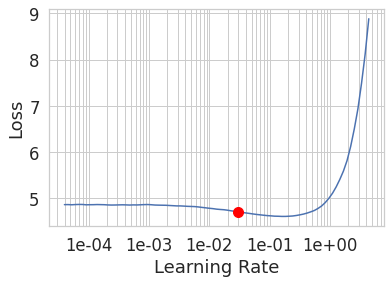

In [27]:
# Show the plot and take the suggested min gradient
raw_model.recorder.plot(show_grid=True, suggestion=True)
min_grad_lr = raw_model.recorder.min_grad_lr

In [28]:
# Train the head of the model 
raw_model.fit_one_cycle(cyc_len=1,max_lr=min_grad_lr,moms=(0.95,0.85))

epoch,train_loss,valid_loss,accuracy,time
0,4.462943,4.063589,0.252604,00:08


In [29]:
# Fine tune model after unfreezing
raw_model.unfreeze()
raw_model.fit_one_cycle(cyc_len=5, max_lr=slice(min_grad_lr/(2.6**4),min_grad_lr), moms=(0.95,0.85))

epoch,train_loss,valid_loss,accuracy,time
0,3.931303,3.962261,0.262165,00:11
1,3.795727,3.997773,0.257292,00:11
2,3.425316,4.039961,0.258036,00:11
3,2.850814,4.209393,0.256994,00:11
4,2.316253,4.367784,0.251786,00:12


In [30]:
# Save all of the model except the task specific layer
raw_model.save_encoder('raw_encoder')

In [31]:
# Gather data for text classification, specifying vocab from our language model
raw_class = TextClasDataBunch.from_csv(path='',csv_name='train_raw.csv',
                              vocab=review_raw.train_ds.vocab,bs=32,text_cols='text',label_cols='sentiment')

In [32]:
# Increase the drop_multi parameter to lower the risk of overfitting for text and classification layers
raw_model = text_classifier_learner(raw_class, AWD_LSTM, drop_mult=0.7)

In [33]:
# Load the previous encoder
raw_model = raw_model.load_encoder('raw_encoder')

In [34]:
# find best learning rate
raw_model.lr_find(start_lr = 1e-05)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-04
Min loss divided by 10: 1.82E-02


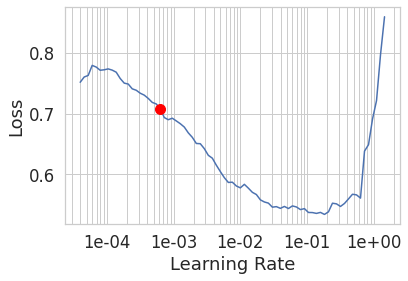

In [35]:
# Set the learning rate to be the suggested one. 
raw_model.recorder.plot(show_grid=True, suggestion=True)
min_grad_lr = raw_model.recorder.min_grad_lr

In [36]:
# Fit with the max/min parameter (moms) as 95% and 85% based on Leslie Smiths suggestion in the paper below
# https://arxiv.org/pdf/1803.09820.pdf
raw_model.fit_one_cycle(cyc_len=1,max_lr=min_grad_lr, moms=(0.95,0.85))

epoch,train_loss,valid_loss,accuracy,time
0,0.549982,0.485333,0.769470,00:05


In [37]:
# freeze all except the last two parameter groups
raw_model.freeze_to(-2)
raw_model.fit_one_cycle(5,slice(min_grad_lr/(2.6**4),min_grad_lr, 5),moms=(0.95,0.85))

epoch,train_loss,valid_loss,accuracy,time
0,0.443355,0.346678,0.881620,00:08
1,0.400613,0.285467,0.894081,00:07
2,0.378589,0.264363,0.906542,00:07
3,0.351274,0.262835,0.912773,00:07
4,0.337652,0.259498,0.906542,00:07


In [38]:
# Continue to unfreeze and train, lowering the moms parameter to move slower through the parameter space.
raw_model.freeze_to(-3)
raw_model.fit_one_cycle(5,slice(min_grad_lr*0.1/(2.6**4),min_grad_lr*0.1, 5), moms = (0.8, 0.7)) 

epoch,train_loss,valid_loss,accuracy,time
0,0.336721,0.261871,0.912773,00:11
1,0.334311,0.254880,0.906542,00:11
2,0.319416,0.251799,0.906542,00:11
3,0.313256,0.257564,0.909657,00:11
4,0.306107,0.248178,0.903427,00:12


In [39]:
# Unfreeze and train the entire model
# Use 10 epochs because of the lowered learning rate and slower moms parameter
raw_model.unfreeze()
raw_model.fit_one_cycle(10,slice(min_grad_lr*0.5/(2.6**4),min_grad_lr*0.5, 10),moms=(0.8, 0.7)) 

epoch,train_loss,valid_loss,accuracy,time
0,0.325898,0.254406,0.906542,00:16
1,0.305565,0.242993,0.912773,00:14
2,0.307236,0.253518,0.897196,00:15
3,0.298956,0.251267,0.903427,00:13
4,0.296095,0.269109,0.900312,00:14
5,0.278075,0.257264,0.903427,00:13
6,0.278259,0.255300,0.900312,00:15
7,0.275675,0.253492,0.909657,00:17
8,0.263632,0.250831,0.903427,00:16
9,0.258958,0.249097,0.909657,00:14


In [40]:
# Make predictions on raw text
test_raw['yelp_senti_pred'] = test_raw['text'].apply(lambda row:str(raw_model.predict(row)[0]))
test_raw['yelp_senti_pred'] = test_raw['yelp_senti_pred'].astype(str).astype(int)

In [41]:
# accuracy: (tp + tn) / (p + n)
print("Accuracy of Model: {}".format(accuracy_score(test_raw['sentiment'],test_raw[
    'yelp_senti_pred'])))
# precision tp / (tp + fp)
print("Precision of Model: {}".format(precision_score(test_raw['sentiment'],test_raw[
    'yelp_senti_pred'])))
# recall: tp / (tp + fn)
print("Recall of Model: {}".format(recall_score(test_raw['sentiment'],test_raw[
    'yelp_senti_pred'])))
# f1: 2 tp / (2 tp + fp + fn)
print("F1 score of Model: {}".format(f1_score(test_raw['sentiment'],test_raw[
    'yelp_senti_pred'])))

Accuracy of Model: 0.885
Precision of Model: 0.8564814814814815
Recall of Model: 0.925
F1 score of Model: 0.889423076923077


In [42]:
cf_matrix = confusion_matrix(test_raw['sentiment'], test_raw['yelp_senti_pred'])
print(cf_matrix)

[[185  15]
 [ 31 169]]


In [43]:
misclassified_text = test_raw[(test_raw.sentiment != test_raw.yelp_senti_pred)][['sentiment','text', 'yelp_senti_pred']]

In [44]:
# The code below will print out all missclassified reviews
'''
LEN_MISSED = len(misclassified_text)

for i in range(LEN_MISSED):
  true_senti = misclassified_text['sentiment'].iloc[i]
  review = misclassified_text['clean_text'].iloc[i]

  print(str(true_senti) + '...' + review + '\n')'''

"\nLEN_MISSED = len(misclassified_text)\n\nfor i in range(LEN_MISSED):\n  true_senti = misclassified_text['sentiment'].iloc[i]\n  review = misclassified_text['clean_text'].iloc[i]\n\n  print(str(true_senti) + '...' + review + '\n')"

In [48]:
#@title
configure_plotly_browser_state()
#Filtering data
review_pos = misclassified_text[misclassified_text["sentiment"]==2].dropna()
review_neg = misclassified_text[misclassified_text["sentiment"]==1].dropna()

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
  token = [token for token in text.lower().split(" ") if token != "" if token not in stop_words]
  ngrams = zip(*[token[i:] for i in range(n_gram)])
  return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from positive reviews ##
freq_dict = defaultdict(int)
for sent in review_pos["text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'red')

# Creating two subplots
fig = tools.make_subplots(rows=2, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of positive reviews", "Frequent words of negative reviews"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace2, 2, 1)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
iplot(fig, filename='word-plots')

/usr/local/lib/python3.6/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [49]:
#@title
configure_plotly_browser_state()
review_neg = misclassified_text.loc[misclassified_text['sentiment'] == 1]
review_pos = misclassified_text.loc[misclassified_text['sentiment'] == 2]
## Get the bar chart from positive reviews ##
freq_dict = defaultdict(int)
for sent in review_pos["text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'brown')



# Creating two subplots
fig = tools.make_subplots(rows=2, cols=1, vertical_spacing=0.04,horizontal_spacing=0.25,
                          subplot_titles=["Bigram plots of Positive reviews",
                                          "Bigram plots of Negative reviews"
                                          ])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace2, 2, 1)


fig['layout'].update(height=1000, width=800, paper_bgcolor='rgb(233,233,233)', title="Bigram Plots")
iplot(fig, filename='word-plots')

/usr/local/lib/python3.6/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



## Clean text run without easy data augmentation.

My initial preprocessing included the cleaning of reviews to get rid of unnecessary characters and any URLs. This training segment is to see the difference between the results of training on raw data versus when the review data is preprocessed beforehand. Fastai already has built in methods of handling text that is capitalized, the beginning of sentences, repeated words among others, so this is to further understand the value in fastai's preprocessing to the outcome of the model. 

In [101]:
# Load text data for preprocessing
review_clean = TextLMDataBunch.from_csv(path='',csv_name='train_clean.csv',valid_pct=0.1)

In [102]:
# Check preprocessing tags from fastai
review_clean.show_batch()

idx,text
0,were okay the burger was pretty simple but slightly undercooked we tried two different types of poutine and were less than thrilled the quality was pretty low and one person in our party did nt feel good after eating the food not sure where all these high reviews are coming in but if i were you i would skip this place and keep moving unless you are maybe drunk high
1,they have daily specials at least during the week i find their prices much better than the mexican restaurants in cave creek and the food selection xxunk course the atmosphere at the el xxunk is better we have never had service that was exceptionally good or exceptionally bad usually the service is about average for area restaurants that are similarly priced xxbos party of for take xxunk thank you never
2,meal that he would nt let us leave until the food was stars we had a xxunk xxunk pizza a xxunk and the garlic knots as well as a few other things that were courtesy of biaggio my buddy is usually really skeptical about the reviews on yelp especially the garlic knots he at his words and the knots we were also able to sample the xxunk bread and the
3,more milk in to save costs because they are not what they use to be xxbos this is a must stop every time we go to vegas for our boys weekend out xxunk for golf gambling and xxunk lawrys vegas easily has the best prime rib i ve ever had and trust me i ve had lots i ve also found that the vegas lawrys is much better and more
4,i ve had some of my favorite rolls of all time here not the best when it comes to california rolls but some of the other options are pretty much fantastic very cool dining area as well i make a point to visit this place at least once a week for a little sake and a lot of sushi they also typically have sports on their several tvs which is


You can see with the batches above that the text requires a lot less labeling. This could result in a loss of information and thus lower the potential of the model to train on the variences of the grammer of reviews.

In [103]:
# Initial language model using AWD_LSTM
clean_model = language_model_learner(review_clean, AWD_LSTM, drop_mult=0.5)

In [104]:
 # Start at 1e-05 to prevent an early local minimum being chosen as the best LR
 clean_model.lr_find(start_lr = 1e-05)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.00E-02
Min loss divided by 10: 1.58E-02


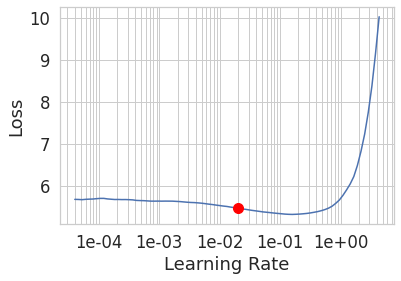

In [105]:
# Plot loss with suggestion
clean_model.recorder.plot(show_grid=True, suggestion=True)
lr = clean_model.recorder.min_grad_lr

In [106]:
# Start with increased moms parameter
clean_model.fit_one_cycle(cyc_len=1,max_lr=lr,moms=(0.95,0.85))

epoch,train_loss,valid_loss,accuracy,time
0,5.156023,4.660439,0.185000,00:07


In [107]:
# Unfreeze and train language model
clean_model.unfreeze()
clean_model.fit_one_cycle(cyc_len=5, max_lr=slice(lr/(2.6**4),lr, 5), moms=(0.95,0.85))

epoch,train_loss,valid_loss,accuracy,time
0,4.603059,4.501516,0.195625,00:10
1,4.405607,4.488266,0.197545,00:10
2,4.017974,4.527024,0.197232,00:10
3,3.484845,4.692743,0.194911,00:09
4,3.004285,4.802141,0.191205,00:09


In [108]:
# Save encoder
clean_model.save_encoder('clean_encoder')

In [109]:
# Load text vocab
clean_class = TextClasDataBunch.from_csv(path='',csv_name='train_clean.csv',
                              vocab=review_clean.train_ds.vocab,bs=32,text_cols='clean_text',label_cols='sentiment')

In [110]:
# Initialize text classifier with text vocab from clean_class
clean_model = text_classifier_learner(clean_class, AWD_LSTM, drop_mult=0.7)

In [111]:
# Set base model with encoder
clean_model = clean_model.load_encoder('clean_encoder')

In [112]:
# Find optimal learning rate
clean_model.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 4.37E-03
Min loss divided by 10: 2.51E-02


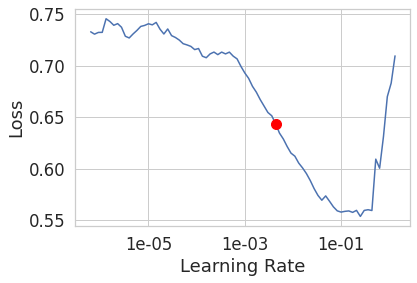

In [113]:
# Plot loss function based on LR
clean_model.recorder.plot(show_grid=True, suggestion=True)
lr = clean_model.recorder.min_grad_lr

In [114]:
# Start training layers
clean_model.fit_one_cycle(cyc_len=1,max_lr=lr,moms=(0.95,0.85))

epoch,train_loss,valid_loss,accuracy,time
0,0.460189,0.301036,0.887850,00:05


In [115]:
# Unfreeze and train more
clean_model.freeze_to(-2)
clean_model.fit_one_cycle(5,slice(lr/(2.6**4),lr, 5), moms=(0.95,0.85))

epoch,train_loss,valid_loss,accuracy,time
0,0.385798,0.250744,0.894081,00:06
1,0.370902,0.231798,0.909657,00:06
2,0.342266,0.217653,0.906542,00:07
3,0.305568,0.202755,0.903427,00:05
4,0.292776,0.194319,0.919003,00:07


In [116]:
# Lower moms parameter and LR to scan parameter space carefully
clean_model.freeze_to(-3)
clean_model.fit_one_cycle(5,slice(lr*0.1/(2.6**4),lr*0.1, 5), moms=(0.8,0.7)) 

epoch,train_loss,valid_loss,accuracy,time
0,0.251539,0.194597,0.919003,00:08
1,0.252185,0.192206,0.919003,00:09
2,0.247584,0.194747,0.909657,00:08
3,0.223163,0.191861,0.909657,00:08
4,0.227535,0.187648,0.915888,00:10


In [117]:
# Final training stage increased to 10 epochs
clean_model.unfreeze()
clean_model.fit_one_cycle(10,slice(lr*0.5/(2.6**4),lr*0.5, 10), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.239909,0.195308,0.912773,00:12
1,0.235329,0.202547,0.912773,00:13
2,0.228611,0.202477,0.915888,00:11
3,0.213222,0.195148,0.919003,00:12
4,0.199114,0.205829,0.912773,00:11
5,0.167888,0.199581,0.906542,00:11
6,0.145565,0.207961,0.909657,00:12
7,0.127197,0.200493,0.919003,00:13
8,0.117688,0.198854,0.922118,00:11
9,0.101312,0.206907,0.906542,00:11


In [118]:
# Predict on test split
test_clean['yelp_senti_pred'] = test_clean['clean_text'].apply(lambda row:str(clean_model.predict(row)[0]))
test_clean['yelp_senti_pred'] = test_clean['yelp_senti_pred'].astype(str).astype(int)

In [119]:
# accuracy: (tp + tn) / (p + n)
print("Accuracy: {}".format(accuracy_score(test_clean['sentiment'],test_clean[
    'yelp_senti_pred'])))
# precision tp / (tp + fp)
print("Precision: {}".format(precision_score(test_clean['sentiment'],test_clean[
    'yelp_senti_pred'])))
# recall: tp / (tp + fn)
print("Recall: {}".format(recall_score(test_clean['sentiment'],test_clean[
    'yelp_senti_pred'])))
# f1: 2 tp / (2 tp + fp + fn)
print("F1 score: {}".format(f1_score(test_clean['sentiment'],test_clean[
    'yelp_senti_pred'])))

Accuracy: 0.8725
Precision: 0.8781725888324873
Recall: 0.865
F1 score: 0.871536523929471


In [120]:
# Confusion Matrix
cf_matrix = confusion_matrix(test_clean['sentiment'], test_clean['yelp_senti_pred'])
print(cf_matrix)

[[173  27]
 [ 24 176]]


In [121]:
# Seperate missclassified text for analysis
misclassified_text = test_clean[(test_clean.sentiment != test_clean.yelp_senti_pred)][['sentiment','clean_text', 'yelp_senti_pred']]

In [122]:
# The code below will print out all missclassified reviews
'''misclassified_text = test_clean[(test_clean.sentiment != test_clean.yelp_senti_pred)][['sentiment','clean_text', 'yelp_senti_pred']]
LEN_MISSED = len(misclassified_text)

for i in range(LEN_MISSED):
  true_senti = misclassified_text['sentiment'].iloc[i]
  review = misclassified_text['clean_text'].iloc[i]

  print(str(true_senti) + '...' + review + '\n')'''

"misclassified_text = test_clean[(test_clean.sentiment != test_clean.yelp_senti_pred)][['sentiment','clean_text', 'yelp_senti_pred']]\nLEN_MISSED = len(misclassified_text)\n\nfor i in range(LEN_MISSED):\n  true_senti = misclassified_text['sentiment'].iloc[i]\n  review = misclassified_text['clean_text'].iloc[i]\n\n  print(str(true_senti) + '...' + review + '\n')"

In [123]:
#@title
configure_plotly_browser_state()
#Filtering data
review_pos = misclassified_text[misclassified_text["sentiment"]==2].dropna()
review_neg = misclassified_text[misclassified_text["sentiment"]==1].dropna()

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
  token = [token for token in text.lower().split(" ") if token != "" if token not in stop_words]
  ngrams = zip(*[token[i:] for i in range(n_gram)])
  return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from positive reviews ##
freq_dict = defaultdict(int)
for sent in review_pos["clean_text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["clean_text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'red')

# Creating two subplots
fig = tools.make_subplots(rows=2, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of positive reviews", "Frequent words of negative reviews"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace2, 2, 1)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
iplot(fig, filename='word-plots')

/usr/local/lib/python3.6/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [124]:
#@title
configure_plotly_browser_state()
review_neg = misclassified_text.loc[misclassified_text['sentiment'] == 1]
review_pos = misclassified_text.loc[misclassified_text['sentiment'] == 2]
## Get the bar chart from positive reviews ##
freq_dict = defaultdict(int)
for sent in review_pos["clean_text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["clean_text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'brown')



# Creating two subplots
fig = tools.make_subplots(rows=2, cols=1, vertical_spacing=0.04,horizontal_spacing=0.25,
                          subplot_titles=["Bigram plots of Positive reviews",
                                          "Bigram plots of Negative reviews"
                                          ])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace2, 2, 1)


fig['layout'].update(height=1000, width=800, paper_bgcolor='rgb(233,233,233)', title="Bigram Plots")
iplot(fig, filename='word-plots')

/usr/local/lib/python3.6/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



## EDA run through

In [135]:
# Load text data for preprocessing
review_eda = TextLMDataBunch.from_csv(path='',csv_name='train_eda.csv',valid_pct=0.1)

In [136]:
review_eda.show_batch()

idx,text
0,at his hair cut its uneven i will just fix it myself instead of going back there they do have videos for the kids to watch but overall it does look outdated into there i wish i had just gone to a regular place xxbos jamburritos is by and far my preferred food truck the chicken jamburrito is amazing their hush puppies are perfectly spiced and their homemade lemonade is
1,out back pizza was bland nothing special xxbos this was the first gourmet chocolate shop i went into and i spent a lot of time here xxunk what to buy considering the chocolate melting during the bus ride what i actually want to eat etc it was difficult choosing and i finally ended up with mik chocolate covered pretzels a hazelnut chocolate bar and one milk chocolate and one dark
2,is that its not very expensive though you can walk around the corner north on clark and get the same food for half the price xxbos i wanted so badly to eat something sweet at the las vegas foodie fest and with the absence of the foxxy ladys cupcakes truck where were they anyways i was desperate while walking around i saw that at tasty buns they had banana potstickers
3,i am up singing when she goes out to the patio she wo nt pull my beer or half smoked smoke most of the patrons are easy going and there is fun karaoke by brad on wednesdays fridays saturdays good selection of songs and brad is fair in the rotation as a finalist in the last competition i can say it was one of the xxunk xxunk i have been
4,d be hard pressed to recommend a better indian curry to my acquaintance the garlic naan was also well done and was a decent portion be it for a slightly exorbitant price more on that below spice level spice levels are more spicy than the the distinctive indian buffet so beware if you have a xxunk constitution my wife was tempted to get hot but lucky enough she settled for


In [137]:
# Set language model with wiki trained base model
eda_model = language_model_learner(review_eda, AWD_LSTM, drop_mult=0.5)

In [138]:
# Find best learning rate based on loss
eda_model.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.31E-02
Min loss divided by 10: 2.51E-02


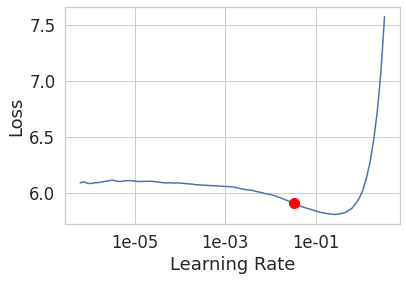

In [139]:
# Set best learning rate suggested by plot
eda_model.recorder.plot(show_grid=True, suggestion=True)
lr = eda_model.recorder.min_grad_lr

In [140]:
# Train language model with suggested learning rate
eda_model.fit_one_cycle(cyc_len=1,max_lr=lr,moms=(0.95,0.85))

epoch,train_loss,valid_loss,accuracy,time
0,5.263464,4.772320,0.185126,00:17


In [141]:
# Unfreeze and train entire LM
eda_model.unfreeze()

In [142]:
eda_model.fit_one_cycle(cyc_len=5, max_lr=slice(lr/(2.6**4),lr, 5), moms=(0.95,0.85))

epoch,train_loss,valid_loss,accuracy,time
0,4.459834,4.488022,0.207549,00:22
1,4.104564,4.232605,0.234213,00:21
2,3.317139,3.842310,0.286201,00:21
3,2.406964,3.515637,0.349026,00:22
4,1.739248,3.436707,0.367918,00:21


In [143]:
# Save base model
eda_model.save_encoder('clean_encoder')

In [144]:
# Load text vocab for text classifier
eda_class = TextClasDataBunch.from_csv(path='',csv_name='train_eda.csv',
                              vocab=review_eda.train_ds.vocab,bs=32,text_cols='eda_text',label_cols='sentiment')

In [145]:
# Initialize specific task for model
eda_model = text_classifier_learner(eda_class, AWD_LSTM, drop_mult=0.7)

In [146]:
# Load base model
eda_model = eda_model.load_encoder('clean_encoder')

In [147]:
# Find best learning rate
eda_model.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 9.12E-03
Min loss divided by 10: 5.25E-02


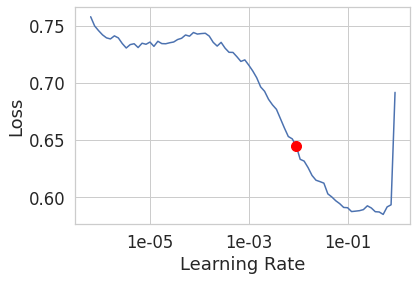

In [148]:
# Set to suggested LR
eda_model.recorder.plot(show_grid=True, suggestion=True)
lr = eda_model.recorder.min_grad_lr

In [149]:
# Begin training
eda_model.fit_one_cycle(cyc_len=1,max_lr=lr,moms=(0.95,0.85))

epoch,train_loss,valid_loss,accuracy,time
0,0.448473,0.322899,0.862715,00:11


In [150]:
# Unfreeze and train one layer at a time
eda_model.freeze_to(-2)
eda_model.fit_one_cycle(5,slice(lr/(2.6**4),lr, 5), moms=(0.95,0.85))

epoch,train_loss,valid_loss,accuracy,time
0,0.373336,0.292529,0.868955,00:12
1,0.349055,0.229040,0.914197,00:13
2,0.298108,0.188449,0.911076,00:13
3,0.253293,0.160657,0.934477,00:12
4,0.212164,0.156825,0.937598,00:12


In [151]:
# Lower moms and LR to scan parameter space 
eda_model.freeze_to(-3)
eda_model.fit_one_cycle(5,slice(lr*0.1/(2.6**4),lr*0.1, 5), moms=(0.8,0.7)) 

epoch,train_loss,valid_loss,accuracy,time
0,0.213840,0.147285,0.940718,00:16
1,0.179523,0.131853,0.950078,00:17
2,0.180615,0.112961,0.960998,00:16
3,0.149835,0.120010,0.959438,00:20
4,0.152126,0.114526,0.964119,00:16


In [152]:
# Unfreeze and train entire model
eda_model.unfreeze()
eda_model.fit_one_cycle(10,slice(lr*0.5/(2.6**4),lr*0.5, 10), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.138551,0.112991,0.962559,00:23
1,0.132270,0.110191,0.970359,00:22
2,0.150117,0.084115,0.973479,00:23
3,0.113267,0.086324,0.973479,00:23
4,0.093171,0.115027,0.967239,00:21
5,0.087581,0.090821,0.973479,00:26
6,0.058077,0.091803,0.968799,00:27
7,0.047268,0.089244,0.979719,00:27
8,0.039058,0.092416,0.975039,00:21
9,0.039000,0.089750,0.975039,00:22


In [160]:
# Predict on raw text
test_clean['yelp_senti_pred'] = test_clean['clean_text'].apply(lambda row:str(eda_model.predict(row)[0]))
test_clean['yelp_senti_pred'] = test_clean['yelp_senti_pred'].astype(str).astype(int)

In [163]:
results = test_clean['yelp_senti_pred']
sentiment = test_clean['sentiment']
# accuracy: (tp + tn) / (p + n)
print("Accuracy: {}".format(accuracy_score(sentiment, results)))
# precision tp / (tp + fp)
print("Precision: {}".format(precision_score(sentiment, results)))
# recall: tp / (tp + fn)
print("Recall: {}".format(recall_score(sentiment, results)))
# f1: 2 tp / (2 tp + fp + fn)
print("F1 score: {}".format(f1_score(sentiment, results)))

Accuracy: 0.895
Precision: 0.8691588785046729
Recall: 0.93
F1 score: 0.8985507246376813


In [164]:
# Print confusion matrix
cf_matrix = confusion_matrix(sentiment, results)
print(cf_matrix)

[[186  14]
 [ 28 172]]


The confusion matrix reveals that our model did better with classifying positive reviews with only 12 misclassified. There were 36 reviews labeled negative that actually turned out to be positive.

In [165]:
# The code below will print out all missclassified reviews
'''misclassified_text = test_raw[(test_raw.sentiment != test_raw.yelp_senti_pred)][['sentiment','text', 'yelp_senti_pred']]
LEN_MISSED = len(misclassified_text)

for i in range(LEN_MISSED):
  true_senti = misclassified_text['sentiment'].iloc[i]
  review = misclassified_text['text'].iloc[i]

  print(str(true_senti) + '...' + review + '\n')'''

"misclassified_text = test_raw[(test_raw.sentiment != test_raw.yelp_senti_pred)][['sentiment','text', 'yelp_senti_pred']]\nLEN_MISSED = len(misclassified_text)\n\nfor i in range(LEN_MISSED):\n  true_senti = misclassified_text['sentiment'].iloc[i]\n  review = misclassified_text['text'].iloc[i]\n\n  print(str(true_senti) + '...' + review + '\n')"

Looking at the misclassified reviews reveals that there are many customers with conflicting feelings about a place. They often start off with what they expected and/or what they appreciated about a business, only to then describe issues with service in often a softer way than they described what they hoped/expected. This led to a monogram breakdown that was very similar as you can see below.

In [166]:
#@title
configure_plotly_browser_state()
#Filtering data
review_pos = misclassified_text[misclassified_text["sentiment"]==2].dropna()
review_neg = misclassified_text[misclassified_text["sentiment"]==1].dropna()

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
  token = [token for token in text.lower().split(" ") if token != "" if token not in stop_words]
  ngrams = zip(*[token[i:] for i in range(n_gram)])
  return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from positive reviews ##
freq_dict = defaultdict(int)
for sent in review_pos["clean_text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["clean_text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'red')

# Creating two subplots
fig = tools.make_subplots(rows=2, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of positive reviews", "Frequent words of negative reviews"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace2, 2, 1)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
iplot(fig, filename='word-plots')

/usr/local/lib/python3.6/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [167]:
#@title
configure_plotly_browser_state()
review_neg = misclassified_text.loc[misclassified_text['sentiment'] == 1]
review_pos = misclassified_text.loc[misclassified_text['sentiment'] == 2]
## Get the bar chart from positive reviews ##
freq_dict = defaultdict(int)
for sent in review_pos["clean_text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["clean_text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'brown')



# Creating two subplots
fig = tools.make_subplots(rows=2, cols=1, vertical_spacing=0.04,horizontal_spacing=0.25,
                          subplot_titles=["Bigram plots of Positive reviews",
                                          "Bigram plots of Negative reviews"
                                          ])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace2, 2, 1)


fig['layout'].update(height=1000, width=800, paper_bgcolor='rgb(233,233,233)', title="Bigram Plots")
iplot(fig, filename='word-plots')

/usr/local/lib/python3.6/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



## Test each model on test data

### Prepare test set

The test set is too large to predict on as is, so a sample will be taken. The set will be cleaned to put less stress on the prediction algorithm also.

In [169]:
# Take sample for reasonable computing time
sample_size = 1000

# Group by sentiment and split the sample to keep the balance of labels
test_sample = test.groupby('sentiment').apply(lambda x: x.sample(sample_size))[['sentiment', 'text']]\
                                         .reset_index(drop=True)

In [170]:
# List of reviews
all_reviews = [text for text in test_sample.text]

# Clean reviews in two ways, onw with only \\n removed and another time with all unnecessary characters removed
all_reviews_no_nn = [remove_nn(text) for text in all_reviews]
all_reviews_no_urls = [review_cleaning(text) for text in all_reviews_no_nn]

# Create a list of lists containing lowercase words for each review
all_reviews_lower = [review.lower() for review in all_reviews_no_urls]

# Create columns for analysis
## Clean text has no unnecessary characters, URLs, etc.
test_sample['clean_text'] = all_reviews_lower
## Raw text is un-touched, except the removal of \\n occurences.
test_sample['text'] = all_reviews_no_nn

### Raw Model

In [175]:
# Predict on raw text
test_sample['pred_raw'] = test_sample['text'].apply(lambda row:str(raw_model.predict(row)[0]))
test_sample['pred_raw'] = test_sample['pred_raw'].astype(str).astype(int)

In [176]:
# accuracy: (tp + tn) / (p + n)
print("Accuracy: {}".format(accuracy_score(test_sample['sentiment'],test_sample[
    'pred_raw'])))

Accuracy: 0.8865


In [177]:
# Print confusion matrix
cf_matrix = confusion_matrix(test_sample['sentiment'], test_sample['pred_raw'])
print(cf_matrix)

[[906  94]
 [133 867]]


### Clean Model

In [178]:
# Predict on raw text
test_sample['pred_clean'] = test_sample['clean_text'].apply(lambda row:str(clean_model.predict(row)[0]))
test_sample['pred_clean'] = test_sample['pred_clean'].astype(str).astype(int)

In [179]:
# accuracy: (tp + tn) / (p + n)
print("Accuracy: {}".format(accuracy_score(test_sample['sentiment'],test_sample[
    'pred_clean'])))

Accuracy: 0.8755


In [180]:
# Print confusion matrix
cf_matrix = confusion_matrix(test_sample['sentiment'], test_sample['pred_clean'])
print(cf_matrix)

[[863 137]
 [112 888]]


### EDA Model

In [181]:
# Predict on raw text
test_sample['pred_eda'] = test_sample['clean_text'].apply(lambda row:str(eda_model.predict(row)[0]))
test_sample['pred_eda'] = test_sample['pred_eda'].astype(str).astype(int)

In [182]:
# accuracy: (tp + tn) / (p + n)
print("Accuracy: {}".format(accuracy_score(test_sample['sentiment'],test_sample[
    'pred_eda'])))

Accuracy: 0.902


In [183]:
# Print confusion matrix
cf_matrix = confusion_matrix(test_sample['sentiment'], test_sample['pred_eda'])
print(cf_matrix)

[[919  81]
 [115 885]]


# Conclusionary Remarks

## Decisions behind hyperparameter choices

My initial parameters for training consisted of a drop_multi parameter of 0.3, finishing with 0.5, a moms parameter of (0.85, 0.75) and a consistent learning rate throughout the training stages. The final choices for the optimal hyperparameters ended up changing significantly. With the aforementioned parameters the model consistently overfit, so the drop_multi parameter was increased to 0.5 and 0.7 for later stages. With the increased drop_multi, this required an increase in momentum which was changed to reflect the suggestion from Leslie Smith's paper on a disciplined approach to tuning hyperparameters. Finally, the learning rate was reduced for the final stages of training. This reduction in learning rate, plus the reduced momentum will ideally allow the model to search through the parameter space more slowly to find the optimal minimum loss. These changes amounted to a more consistent model that was less prone to overfitting.

## Final Results

The best results were achieved using EDA on review text data for a more robust training set. This introduces new words to the vocabulary and can allow for the model to become more versatile and able to predict better on new data. While the final accuracy was a little over 90%, it did outperform the models trained on the raw and manually cleaned reviews consistently. I did have some scepticism that this may be the result of simply having more training data, so rest assured I did train the models on greater training sizes and did in fact see the same results.

For the raw text, it seemed to consistently outperform the clean text model. This may be because fastai's built in preprocessing allows for more information to be given to the model during training that eventually improves its ability to predict with new data. For the final eda model however, it was much more successful when predictions were made using preprocessed text. This may be because EDA not only transforms the reviews but processes the text as well, thus making it more familiar with clean data.

Next steps in this project will be to gain a better understanding of how EDA can help based on model outcome. For example, my model was having trouble with reviews that had a mixed sentiment. An example of this would be someone who writes about a positive expectation, only to have a negative experience. Is there a way to manipulate the EDA to build a training set more capable of training a model to recognize the true sentiment of these mixed reviews? I also need to gain a greater understanding of how the the learning rate, momentum and number of epochs together contribute to the model outcome to understand more impactful ways of manipulating them.

Overall I believe the model I created performed well. The misclassified reviews were ones you may expect a model to mistake. How can I train a model to understand that the statement, "I will never eat at any other chinese restaurant" it positive? There is still much work to be done.